<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/019_SINDy_Proj_Nineteen_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install pysindy

In [ ]:
# utils
import sys, os
import requests
import warnings
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.linalg import LinAlgWarning
from scipy.io import loadmat
from pathlib import Path
from contextlib import contextmanager
from copy import copy
# google
from google.colab import drive
# sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit, ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, ShuffleSplit
from sklearn.metrics import r2_score
# pysindy
import pysindy as ps
from pysindy.utils import (enzyme, lorenz, lorenz_control)
# vis
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
try: # for inequality constraints
    import cvxpy
    run_cvxpy = True
except ImportError:
    run_cvxpy = False
    print("No CVXPY package is installed")

In [ ]:
try:
    import gurobipy
    run_miosr = True
    GurobiError = gurobipy.GurobiError
except ImportError:
    run_miosr = False

In [ ]:
if __name__ != "unit_test":
    time_end_train = 10
    time_end_test = 15
else:
    time_end_train = 0.2
    time_end_test = 0.4
    sys.stdout = open(os.devnull, "w")

In [ ]:
@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters

In [ ]:
drive.mount('/content/drive') # mount google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# working_dir = '/content/drive/MyDrive/DataSets/PySINDy_Data'
# os.listdir(working_dir)

In [ ]:
data = (Path() / "drive/MyDrive/DataSets/PySINDy_Data").resolve()
data

PosixPath('/content/drive/MyDrive/DataSets/PySINDy_Data')

In [ ]:
print(__name__)

__main__


## Feature Overview

In [ ]:
np.random.seed(100)

In [ ]:
# integrator keywords for "solve_ivp" to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA" # the default solver for `solve_ivp` is the Runga-Kutta method (RK45)
                                        # but this seems to work quite poorly on a number of problems
                                        # likely because they are multi-scale and chaotic
integrator_keywords["atol"] = 1e-12

### Chapter One

Fit a SINDy model to the Lorenz system:
$$\dot{x} = \sigma (y - x)$$
$$\dot{y} = x(\rho - z) - y$$
$$\dot{z} = x y - \beta z$$

In [ ]:
# def lorenz(t, x, sigma=10, beta=2.66667, rho=28): # Lorenz model
#     return [
#         sigma * (x[1] - x[0]),
#         x[0] * (rho - x[2]) - x[1],
#         x[0] * x[1] - beta * x[2],
#     ]

In [ ]:
# gen measurement data
dt = 0.002
t_train = np.arange(0, time_end_train, dt)
init_cond_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
solver = solve_ivp(lorenz, t_train_span, init_cond_train, t_eval=t_train, **integrator_keywords)
x_train = solver.y
x_train = x_train.T

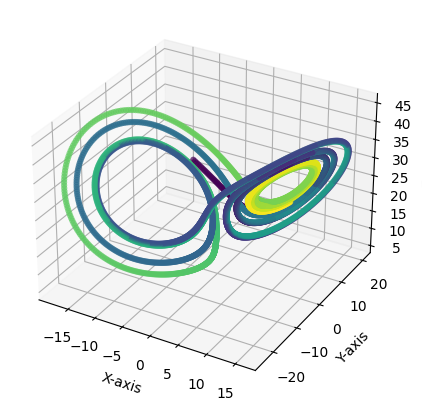

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], x_train[:,2], c=t_train, marker='o', edgecolors='None', alpha=0.7)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

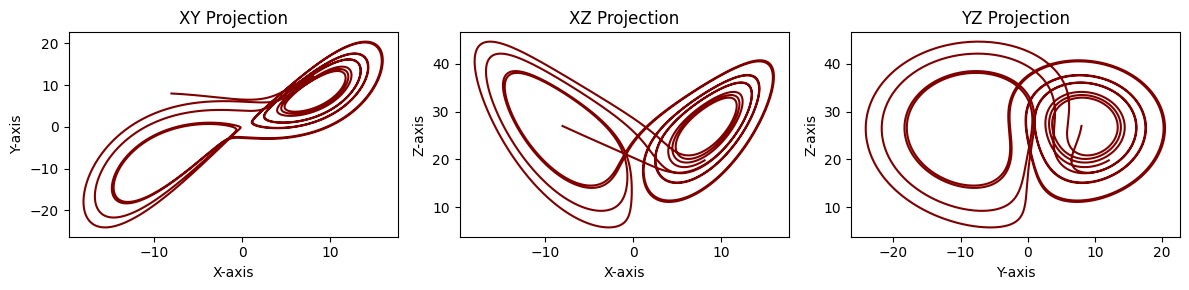

In [ ]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 3, 1)
ax.plot(x_train[:,0], x_train[:,1], c='maroon')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('XY Projection')
ax = fig.add_subplot(1, 3, 2)
ax.plot(x_train[:,0], x_train[:,2], c='maroon')
ax.set_xlabel('X-axis')
ax.set_ylabel('Z-axis')
ax.set_title('XZ Projection')
ax = fig.add_subplot(1, 3, 3)
ax.plot(x_train[:,1], x_train[:,2], c='maroon')
ax.set_xlabel('Y-axis')
ax.set_ylabel('Z-axis')
ax.set_title('YZ Projection')
plt.tight_layout()
plt.show()

In [ ]:
# instantiate and fit the SINDy model
model = ps.SINDy(feature_names=['x', 'y', 'z'])
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


In [ ]:
model.get_feature_names()

['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']

In [ ]:
model.coefficients()

array([[ 0.        , -9.99920727,  9.99920677,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 27.99222777, -0.99852754,  0.        ,  0.        ,
         0.        , -0.9997802 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -2.6663641 ,  0.        ,
         0.99988322,  0.        ,  0.        ,  0.        ,  0.        ]])

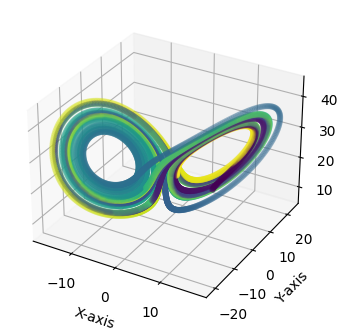

In [ ]:
# evolve the Lorenz eqs in time using a different initial condition
t_test = np.arange(0, time_end_test, dt)
init_cond_test = np.array([8, 7, 15])
t_test_span = (t_test[0], t_test[-1])
solver = solve_ivp(lorenz, t_test_span, init_cond_test, t_eval=t_test, **integrator_keywords)
x_test = solver.y
x_test = x_test.T
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_test[:,0], x_test[:,1], x_test[:,2], c=t_test, marker='o', edgecolors='None', alpha=0.3)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# compare SINDy predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(x_test, t=dt))

Model score: 1.000000


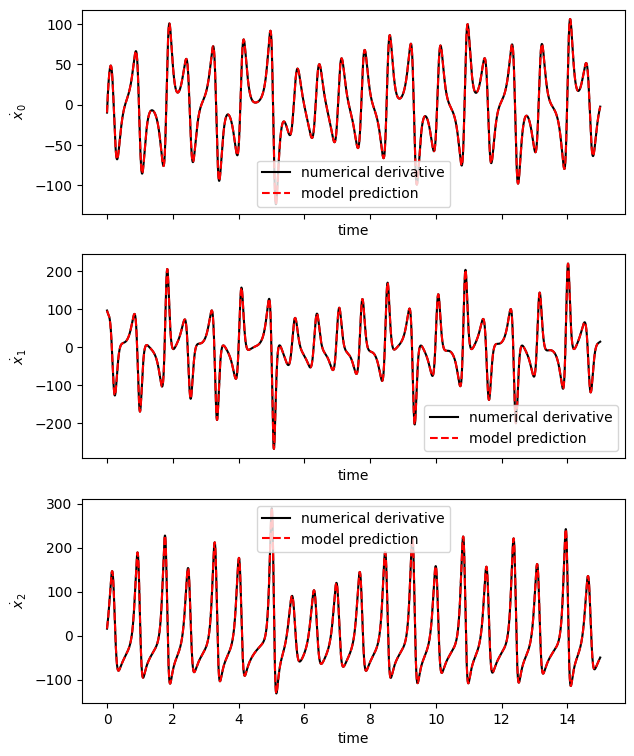

In [ ]:
x_dot_pred = model.predict(x_test) #  derivatives using the learned model
x_dot_comp = model.differentiate(x_test, t=dt) # derivatives with the finite difference method
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_comp[:, i], "k", label="numerical derivative")
    axs[i].plot(t_test, x_dot_pred[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="time", ylabel=r"$\dot x_{}$".format(i))
fig.show()

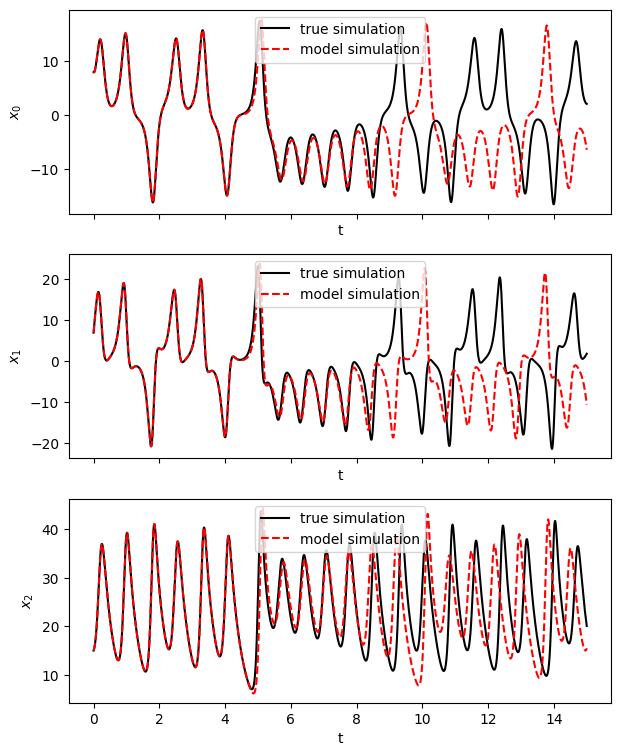

In [ ]:
# evolve the new initial condition in time with the SINDy model
x_simulate = model.simulate(init_cond_test, t_test)
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], "k", label="true simulation")
    axs[i].plot(t_test, x_simulate[:, i], "r--", label="model simulation")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel="$x_{}$".format(i))

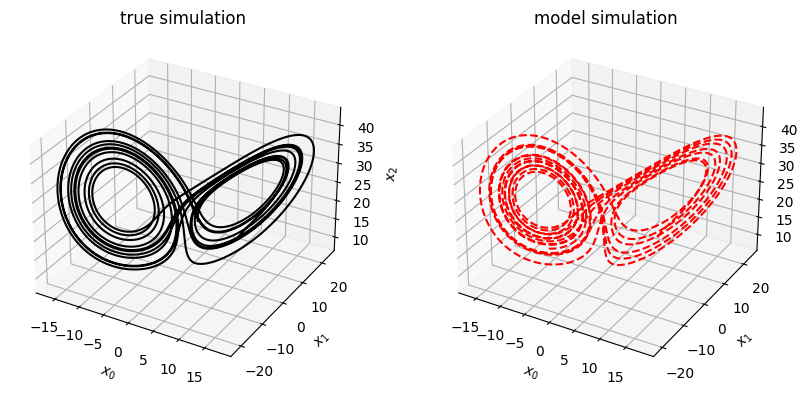

In [ ]:
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k")
ax1.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$", title="true simulation")
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(x_simulate[:, 0], x_simulate[:, 1], x_simulate[:, 2], "r--")
ax2.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$", title="model simulation")
fig.show()

### Chapter Two

In [ ]:
# gen measurement data
dt = 0.002
t_train = np.arange(0, time_end_train, dt)
init_cond_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
solver = solve_ivp(lorenz, t_train_span, init_cond_train, t_eval=t_train, **integrator_keywords)
x_train = solver.y
x_train = x_train.T

In [ ]:
model = ps.SINDy()
model.fit(x_train, t=t_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
model = ps.SINDy(t_default=dt)
model.fit(x_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
v_true = np.zeros_like(x_train)
for i in range(t_train.size):
    v_true[i] = lorenz(t_train[i], x_train[i])
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=v_true)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [ ]:
num_trajectories = 20
init_conds = np.array([36, 48, 41]) * (np.random.rand(num_trajectories, 3) - 0.5) + np.array([0, 0, 25])
x_train = []
for i in range(num_trajectories):
    x_train.append(solve_ivp(lorenz, t_train_span, init_conds[i],
                             t_eval=t_train, **integrator_keywords).y.T)
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

In [ ]:
sample_range = (500, 1500)
init_conds = np.array([36, 48, 41]) * (np.random.rand(num_trajectories, 3) - 0.5) + np.array([0, 0, 25])
x_train, t_train = [], []
for i in range(num_trajectories):
    n_samples = np.random.randint(*sample_range)
    t = np.arange(0, n_samples * dt, dt)
    t_span = (t[0], t[-1])
    x_train.append(solve_ivp(lorenz, t_span, init_conds[i], t_eval=t, **integrator_keywords).y.T)
    t_train.append(t)
model = ps.SINDy()
model.fit(x_train, t=t_train)
model.print()

In [ ]:
def f(x):
    return 3.6 * x * (1 - x)

if __name__ != "unit_test":
    n_steps = 1000
else:
    n_steps = 10

eps = 0.001  # noise level
x_train = np.zeros((n_steps))
x_train[0] = 0.5
for i in range(1, n_steps):
    x_train[i] = f(x_train[i - 1]) + eps * np.random.randn()
model = ps.SINDy(discrete_time=True)
model.fit(x_train)
model.print()

(x0)[k+1] = 0.001 1 + 3.598 x0[k] + -3.598 x0[k]^2


In [ ]:
# gen measurement data
dt = 0.002
t_train = np.arange(0, time_end_train, dt)
init_cond_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
solver = solve_ivp(lorenz, t_train_span, init_cond_train, t_eval=t_train, **integrator_keywords)
x_train = solver.y
x_train = x_train.T
df = pd.DataFrame(data=x_train, columns=["x", "y", "z"], index=t_train)
model = ps.SINDy(feature_names=df.columns)
model.fit(df.values, t=df.index.values)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


In [ ]:
stlsq_optim = ps.STLSQ(threshold=0.01, alpha=0.5)
model = ps.SINDy(optimizer=stlsq_optim)
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
sr3_optim = ps.SR3(threshold=0.1, thresholder="l1")
model = ps.SINDy(optimizer=sr3_optim)
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
outliers_inds = np.random.randint(0, len(x_train), size=len(x_train)//20)
x_train_corr = x_train.copy()
x_train_corr[outliers_inds] += np.random.standard_normal((len(outliers_inds), 3))
sr3_optim = ps.SR3() # without trimming
with ignore_specific_warnings():
    model = ps.SINDy(optimizer=sr3_optim).fit(x_train_corr, t=dt)
print("Without trimming")
model.print()
print("Model score: %f" % model.score(x_train, t=dt))
sr3_optim = ps.SR3(trimming_fraction=0.1) # with trimming
with ignore_specific_warnings():
    model = ps.SINDy(optimizer=sr3_optim).fit(x_train_corr, t=dt)
print("\nWith trimming")
model.print()
print("Model score: %f" % model.score(x_train, t=dt))

Without trimming
(x0)' = 0.339 1 + -9.925 x0 + 9.921 x1 + -0.009 x2
(x1)' = -2.257 1 + 27.725 x0 + -0.925 x1 + 0.128 x2 + -0.032 x0^2 + 0.021 x0 x1 + -0.993 x0 x2
(x2)' = -0.021 1 + -2.663 x2 + 0.999 x0 x1
Model score: 0.999942

With trimming
(x0)' = 0.339 1 + -9.925 x0 + 9.921 x1 + -0.009 x2
(x1)' = -0.025 1 + 27.782 x0 + -0.937 x1 + -0.994 x0 x2
(x2)' = -0.004 1 + 0.019 x0 + -0.028 x1 + -2.662 x2 + 0.999 x0 x1
Model score: 0.999970


In [ ]:
sr3_optimizer = ps.SR3(threshold=0.1, thresholder="l0")
with ignore_specific_warnings():
    model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt)
print("L0 regularizer: ")
model.print()
sr3_optimizer = ps.SR3(threshold=0.1, thresholder="l1")
with ignore_specific_warnings():
    model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt)
print("L1 regularizer: ")
model.print()
sr3_optimizer = ps.SR3(threshold=0.1, thresholder="l2")
with ignore_specific_warnings():
    model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt)
print("L2 regularizer: ") # pure L2 option is notably less sparse than the other options
model.print()

L0 regularizer: 
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
L1 regularizer: 
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
L2 regularizer: 
(x0)' = -0.001 1 + -10.005 x0 + 10.003 x1
(x1)' = -0.015 1 + 27.991 x0 + -0.998 x1 + 0.002 x2 + -1.000 x0 x2
(x2)' = 0.008 1 + 0.006 x0 + -0.004 x1 + -2.666 x2 + 0.001 x0^2 + 0.999 x0 x1


In [ ]:
sr3_optimizer = ps.SR3(threshold=0.1, thresholder="l0")
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt)
print("Threshold = 0.1 for all terms")
model.print()
thresholds = 2 * np.ones((10, 3)) # thresholds matrix
thresholds[4:, :] = 0.1
sr3_optimizer = ps.SR3(thresholder="weighted_l0", thresholds=thresholds)
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt)
print("Threshold = 0.1 for quadratic terms, else threshold = 1")
model.print()

Threshold = 0.1 for all terms
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
Threshold = 0.1 for quadratic terms, else threshold = 1
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 25.563 x0 + -0.952 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
lib = ps.PolynomialLibrary()
lib.fit([ps.AxesArray(x_train, {"ax_sample": 0, "ax_coord": 1})])
num_features = lib.n_output_features_
print(f"{num_features} features:", lib.get_feature_names())
num_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28])
constraint_lhs = np.zeros((2, num_targets * num_features)) # one row per constraint, one column per coefficient
constraint_lhs[0, 1], constraint_lhs[0, 2] = 1, 1 # 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[1, 1 + num_features] = 1 # 1 * (x0 coefficient) = 28
optim = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model = ps.SINDy(optimizer=optim, feature_library=lib).fit(x_train, t=dt)
model.print()

10 features: ['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']
(x0)' = -10.002 x0 + 10.002 x1
(x1)' = 28.000 x0 + -1.003 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


In [ ]:
lib = ps.PolynomialLibrary()
lib.fit([ps.AxesArray(x_train, {"ax_sample": 0, "ax_coord": 1, "ax_coord": 2})])
num_features = lib.n_output_features_
print(f"{num_features} features:", lib.get_feature_names())
num_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28, -3])
constraint_lhs = np.zeros((3, num_targets * num_features)) # one row per constraint, one column per coefficient
constraint_lhs[0, 1], constraint_lhs[0, 2] = 1, 1 # 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[1, 1 + num_features] = 1 # 1 * (x0 coefficient) = 28
constraint_lhs[2, 2 + 2 * num_features] = 1 # 1 * (x1 coefficient) = -3
optim = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model = ps.SINDy(optimizer=optim, feature_library=lib).fit(x_train, t=dt)
model.print()

10 features: ['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']
(x0)' = -10.002 x0 + 10.002 x1
(x1)' = 28.000 x0 + -1.003 x1 + -1.000 x0 x2
(x2)' = -4.680 1 + 4.381 x0 + -3.000 x1 + -2.156 x2 + 0.927 x0 x1 + -0.124 x0 x2


In [ ]:
# try with normalize columns (doesn't work with constraints!!!)
optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    normalize_columns=True,
    threshold=10)
with ignore_specific_warnings():
    model = ps.SINDy(optimizer=optim, feature_library=lib).fit(x_train, t=dt)
model.print()

(x0)' = -10.002 x0 + 10.002 x1
(x1)' = 28.000 x0 + -1.003 x1 + -1.000 x0 x2
(x2)' = -4.680 1 + 4.381 x0 + -3.000 x1 + -2.156 x2 + 0.927 x0 x1 + -0.124 x0 x2


In [ ]:
if run_cvxpy:
    eps = 1e-5
    constraint_rhs = np.array([eps, eps, 28])
    constraint_lhs = np.zeros((3, num_targets * num_features)) # one row per constraint, one column per coefficient
    constraint_lhs[0, 1], constraint_lhs[0, 2] = 1, 1 # 1 * (x0 coefficient) + 1 * (x1 coefficient) <= eps
    constraint_lhs[1, 1], constraint_lhs[1, 2] = -1, -1 # -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient)
    constraint_lhs[2, 1 + num_features] = 1 # -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient)
    optimizer = ps.ConstrainedSR3(
        constraint_rhs=constraint_rhs,
        constraint_lhs=constraint_lhs,
        inequality_constraints=True,
        thresholder="l1",
        tol=1e-7,
        threshold=10,
        max_iter=10000)
    model = ps.SINDy(optimizer=optimizer, feature_library=lib).fit(x_train, t=dt)
    model.print()
    print(optimizer.coef_[0, 1], optimizer.coef_[0, 2])

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.985 x0 + -0.994 x1 + -1.000 x0 x2
(x2)' = 0.001 x0 + -2.665 x2 + 0.001 x0^2 + 0.999 x0 x1
-10.000125845131029 10.000135827965188


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
if run_miosr:
    try:
        miosr_optimizer = ps.MIOSR(target_sparsity=7)
        model = ps.SINDy(optimizer=miosr_optimizer)
        model.fit(x_train, t=dt)
        model.print()
    except GurobiError:
        print("User has an expired gurobi license")

In [ ]:
if run_miosr:
    try:
        miosr_optimizer = ps.MIOSR(group_sparsity=(2, 3, 2), target_sparsity=None)

        model = ps.SINDy(optimizer=miosr_optimizer)
        model.fit(x_train, t=dt)
        model.print()
    except GurobiError:
        print("User does not have a gurobi license")

In [ ]:
if run_miosr:
    try:
        num_targets = x_train.shape[1]
        constraint_rhs = np.array([0, 28])
        constraint_lhs = np.zeros((2, num_targets * num_features))
        constraint_lhs[0, 1], constraint_lhs[0, 2] = 1, 1 # 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
        constraint_lhs[1, 1 + num_features] = 1 # 1 * (x0 coefficient) = 28
        miosr_optimizer = ps.MIOSR(
            constraint_rhs=constraint_rhs,
            constraint_lhs=constraint_lhs,
            verbose=True,  # print the full gurobi log
            target_sparsity=7)
        model = ps.SINDy(optimizer=miosr_optimizer, feature_library=lib)
        model.fit(x_train, t=dt)
        model.print()
        print(optimizer.coef_[0, 1], optimizer.coef_[0, 2])
    except GurobiError:
        print("User does not have a gurobi license")

In [ ]:
ssr_optim = ps.SSR(alpha=0.05)
model = ps.SINDy(optimizer=ssr_optim)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.001 1 + -10.005 x0 + 10.003 x1
(x1)' = -0.015 1 + 27.991 x0 + -0.998 x1 + 0.002 x2 + -1.000 x0 x2
(x2)' = 0.008 1 + 0.006 x0 + -0.004 x1 + -2.666 x2 + 0.001 x0^2 + 0.999 x0 x1


In [ ]:
ssr_optim = ps.SSR(alpha=0.05, criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optim)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.001 1 + -10.005 x0 + 10.003 x1
(x1)' = -0.015 1 + 27.991 x0 + -0.998 x1 + 0.002 x2 + -1.000 x0 x2
(x2)' = 0.008 1 + 0.006 x0 + -0.004 x1 + -2.666 x2 + 0.001 x0^2 + 0.999 x0 x1


In [ ]:
ssr_optim= ps.SSR(alpha=0.05, criteria="model_residual", kappa=1e-3)
model = ps.SINDy(optimizer=ssr_optim)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.004 x0 + 10.003 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.665 x2 + 1.000 x0 x1


In [ ]:
optimizer = ps.FROLS(alpha=0.05)
model = ps.SINDy(optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.001 1 + -10.005 x0 + 10.003 x1
(x1)' = -0.005 1 + 27.990 x0 + -0.997 x1 + -1.000 x0 x2
(x2)' = 0.019 1 + -2.668 x2 + 0.999 x0 x1


In [ ]:
optimizer = ps.FROLS(alpha=0.05, kappa=1e-7)
model = ps.SINDy(optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -0.001 1 + -2.666 x2 + 1.000 x0 x1


In [ ]:
lasso_optimizer = Lasso(alpha=2, max_iter=2000, fit_intercept=False)
model = ps.SINDy(optimizer=lasso_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.005 x0 + 10.003 x1
(x1)' = 27.990 x0 + -0.997 x1 + -1.000 x0 x2
(x2)' = -2.665 x2 + 1.000 x0 x1


### Chapter Three

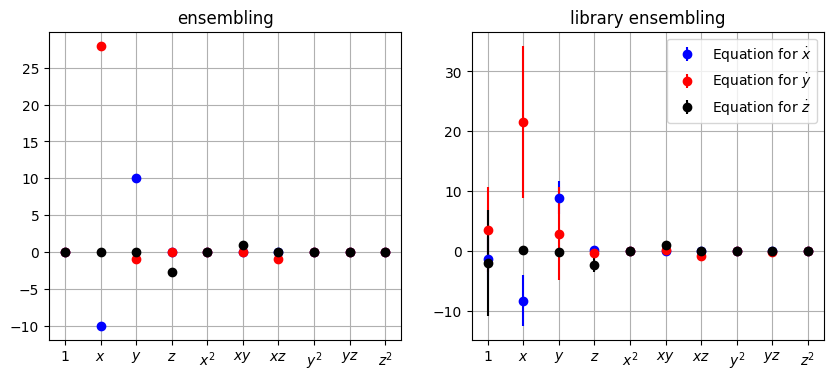

In [ ]:
# default is to sample the entire time series with replacement, generating 10 models on roughly 60% of the total data, with duplicates
np.random.seed(100)
feature_names = ["x", "y", "z"]
ensemble_optimizer = ps.EnsembleOptimizer(
    ps.STLSQ(threshold=1e-3, normalize_columns=False),
    bagging=True,
    n_subset=int(0.6 * x_train.shape[0]))
model = ps.SINDy(optimizer=ensemble_optimizer, feature_names=feature_names)
model.fit(x_train, t=dt)
ensemble_coefs = ensemble_optimizer.coef_list
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)
# we sub-sample the library
# the default is to omit a single library term
library_ensemble_optimizer = ps.EnsembleOptimizer(
    ps.STLSQ(threshold=1e-3, normalize_columns=False), library_ensemble=True)
model = ps.SINDy(optimizer=library_ensemble_optimizer, feature_names=feature_names)
model.fit(x_train, t=dt)
library_ensemble_coefs = library_ensemble_optimizer.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)
# plot
xticknames = model.get_feature_names()
for i in range(10):
    xticknames[i] = "$" + xticknames[i] + "$"
plt.figure(figsize=(10, 4))
colors = ["b", "r", "k"]
plt.subplot(1, 2, 1)
plt.title("ensembling")
for i in range(3):
    plt.errorbar(
        range(10),
        mean_ensemble[i, :],
        yerr=std_ensemble[i, :],
        fmt="o",
        color=colors[i],
        label=r"Equation for $\dot{" + feature_names[i] + r"}$")
ax = plt.gca()
plt.grid(True)
ax.set_xticks(range(10))
ax.set_xticklabels(xticknames, verticalalignment="top")
plt.subplot(1, 2, 2)
plt.title("library ensembling")
for i in range(3):
    plt.errorbar(
        range(10),
        mean_library_ensemble[i, :],
        yerr=std_library_ensemble[i, :],
        fmt="o",
        color=colors[i],
        label=r"Equation for $\dot{" + feature_names[i] + r"}$")
ax = plt.gca()
plt.grid(True)
plt.legend()
ax.set_xticks(range(10))
ax.set_xticklabels(xticknames, verticalalignment="top")
plt.show()

### Chapter Four

In [ ]:
v_precomp = ps.FiniteDifference()._differentiate(x_train, t_train)
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=v_precomp)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
drop_endpoints = ps.FiniteDifference(drop_endpoints=True)
model = ps.SINDy(differentiation_method=drop_endpoints)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


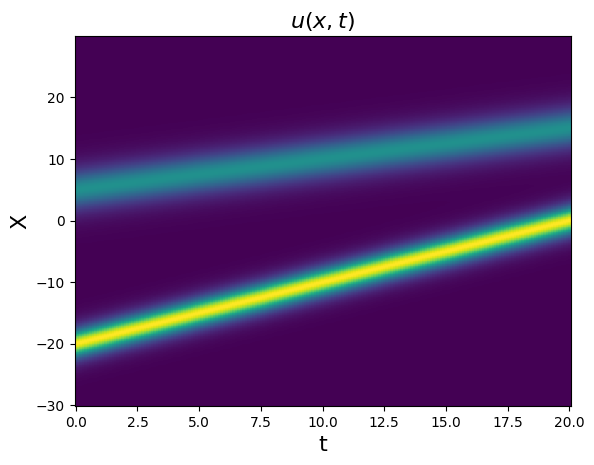

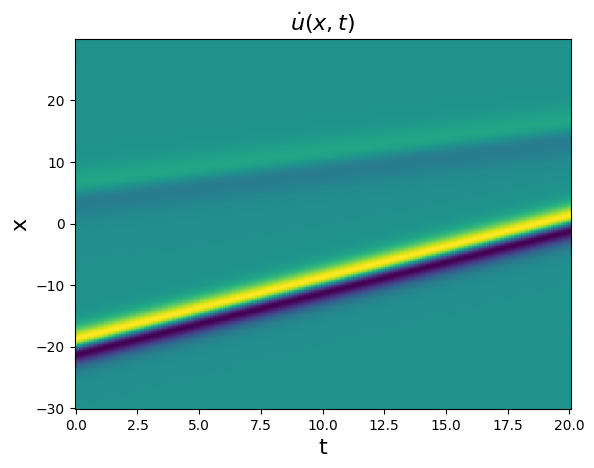

In [ ]:
kdV = loadmat(data / "kdv.mat") # load the data stored in a matlab .mat file
t = np.ravel(kdV["t"])
X = np.ravel(kdV["x"])
x = np.real(kdV["usol"])
dt_kdv = t[1] - t[0]
plt.figure()
plt.pcolormesh(t, X, x)
plt.xlabel("t", fontsize=16)
plt.ylabel("X", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.figure()
x_dot = ps.FiniteDifference(axis=1)._differentiate(x, t=dt_kdv) # differentiation along specific array axis
plt.pcolormesh(t, X, x_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$\dot{u}(x, t)$", fontsize=16)
plt.show()

In [ ]:
smooth_diff = ps.SmoothedFiniteDifference()
model = ps.SINDy(differentiation_method=smooth_diff)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
spline_derivative = ps.SINDyDerivative(kind="spline", s=1e-2)
model = ps.SINDy(differentiation_method=spline_derivative)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.003 x0 + -1.001 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


### Chapter Five

In [ ]:
feature_names = ["x", "y", "z"]
model = ps.SINDy(feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


In [ ]:
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print(lhs=["dx0/dt", "dx1/dt", "dx2/dt"])
print("Model score: %f" % model.score(x_train, t=dt))

dx0/dt = -9.999 x0 + 9.999 x1
dx1/dt = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
dx2/dt = -2.666 x2 + 1.000 x0 x1
Model score: 1.000000


In [ ]:
poly_library = ps.PolynomialLibrary(include_interaction=False)
model = ps.SINDy(feature_library=poly_library, optimizer=ps.STLSQ(threshold=0.5))
model.fit(x_train, t=dt)
model.print()
print("Model score: %f" % model.score(x_train, t=dt))

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = -12.142 x0 + 9.349 x1
(x2)' = 85.861 1 + 0.567 x0 + -7.354 x2 + 1.366 x0^2
Model score: 0.796946


In [ ]:
fourier_library = ps.FourierLibrary(n_frequencies=3)
model = ps.SINDy(feature_library=fourier_library, optimizer=ps.STLSQ(threshold=4))
model.fit(x_train, t=dt)
model.print()
print("Model score: %f" % model.score(x_train, t=dt))

(x0)' = 6.201 cos(1 x1)
(x1)' = -4.233 cos(1 x0) + -4.817 sin(1 x2) + 7.787 cos(1 x2) + -5.604 cos(2 x0) + 4.630 cos(3 x0) + 4.569 sin(3 x2)
(x2)' = 4.982 sin(1 x0) + 4.768 sin(1 x1) + -13.709 cos(2 x1) + 4.674 sin(3 x1) + -8.713 cos(3 x1)
Model score: 0.020785


In [ ]:
fourier_library = ps.FourierLibrary(n_frequencies=2)
model = ps.SINDy(feature_library=fourier_library, optimizer=ps.STLSQ(threshold=4))
model.fit(x_train, t=dt)
print(fourier_library.get_feature_names())

['sin(1 x0)', 'cos(1 x0)', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'sin(2 x0)', 'cos(2 x0)', 'sin(2 x1)', 'cos(2 x1)', 'sin(2 x2)', 'cos(2 x2)']


In [ ]:
library_functions = [
    lambda x: np.exp(x),
    lambda x: 1.0 / x,
    lambda x: x,
    lambda x, y: np.sin(x + y),
]
library_function_names = [
    lambda x: "exp(" + x + ")",
    lambda x: "1/" + x,
    lambda x: x,
    lambda x, y: "sin(" + x + "," + y + ")",
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)
model = ps.SINDy(feature_library=custom_library)
with ignore_specific_warnings():
    model.fit(x_train, t=dt)
model.print()
print("Model score: %f" % model.score(x_train, t=dt))

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 1.197 1/x0 + -50.011 1/x2 + -12.462 x0 + 9.291 x1 + 0.383 x2 + 0.882 sin(x0,x1) + 1.984 sin(x0,x2) + -0.464 sin(x1,x2)
(x2)' = 0.874 1/x0 + -8.545 1/x2 + 0.114 x0 + 0.147 x1 + 3.659 sin(x0,x1) + -3.302 sin(x0,x2) + -3.094 sin(x1,x2)
Model score: 0.509908


In [ ]:
library_functions = [
    lambda x: np.exp(x),
    lambda x: 1.0 / x,
    lambda x: x,
    lambda x, y: np.sin(x + y),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

model = ps.SINDy(feature_library=custom_library)
with ignore_specific_warnings():
    model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 f2(x0) + 9.999 f2(x1)
(x1)' = 1.197 f1(x0) + -50.011 f1(x2) + -12.462 f2(x0) + 9.291 f2(x1) + 0.383 f2(x2) + 0.882 f3(x0,x1) + 1.984 f3(x0,x2) + -0.464 f3(x1,x2)
(x2)' = 0.874 f1(x0) + -8.545 f1(x2) + 0.114 f2(x0) + 0.147 f2(x1) + 3.659 f3(x0,x1) + -3.302 f3(x0,x2) + -3.094 f3(x1,x2)


In [ ]:
identity_library = ps.IdentityLibrary()
model = ps.SINDy(feature_library=identity_library)
model.fit(x_train, t=dt)
model.print()
print(identity_library.get_feature_names())

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = -12.450 x0 + 9.314 x1 + 0.299 x2
(x2)' = 0.257 x0
['x0', 'x1', 'x2']


In [ ]:
identity_library = ps.IdentityLibrary()
fourier_library = ps.FourierLibrary()
combined_library = identity_library + fourier_library
model = ps.SINDy(feature_library=combined_library, feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()
model.get_feature_names()

(x)' = -9.999 x + 9.999 y
(y)' = -12.512 x + 9.391 y + 0.302 z + -2.969 sin(1 x) + -3.341 cos(1 x) + -1.027 sin(1 y) + -6.675 cos(1 y) + -1.752 sin(1 z) + 3.392 cos(1 z)
(z)' = 0.120 x + 0.140 y + 5.950 sin(1 x) + 2.661 cos(1 x) + 7.917 sin(1 y) + -4.030 cos(1 y) + -1.238 sin(1 z) + -0.280 cos(1 z)


['x',
 'y',
 'z',
 'sin(1 x)',
 'cos(1 x)',
 'sin(1 y)',
 'cos(1 y)',
 'sin(1 z)',
 'cos(1 z)']

(x)' = 1.127 x sin(1 y) + -14.067 x cos(1 y) + 0.247 x sin(1 z) + -0.780 x cos(1 z) + 0.182 y cos(1 x) + -0.208 y sin(1 y) + 8.096 y cos(1 y) + -0.324 y sin(1 z) + 0.446 y cos(1 z) + 2.015 z sin(1 y) + 0.480 z cos(1 y) + 1.002 x^2 sin(1 y) + -0.917 x y sin(1 y) + 0.371 x z cos(1 y) + 0.197 y^2 sin(1 y) + -0.215 y z cos(1 y) + -0.115 z^2 sin(1 y)
(y)' = 15.924 x sin(1 x) + 0.739 x cos(1 x) + 1.201 x sin(1 y) + -0.213 x cos(1 y) + 1.108 x sin(1 z) + -1.897 x cos(1 z) + -4.645 y sin(1 x) + -0.968 y sin(1 y) + -0.729 y sin(1 z) + 0.640 y cos(1 z) + -0.315 z sin(1 x) + -0.267 z cos(1 x) + 0.101 z sin(1 z) + 2.511 z cos(1 z) + 0.276 x^2 sin(1 x) + -0.365 x^2 sin(1 z) + 1.069 x^2 cos(1 z) + -0.665 x y sin(1 x) + -0.290 x y cos(1 x) + 0.233 x y sin(1 z) + -0.698 x y cos(1 z) + -0.396 x z sin(1 x) + 0.326 y^2 sin(1 x) + 0.196 y^2 cos(1 x) + -0.113 z^2 cos(1 z)
(z)' = 18.768 x cos(1 x) + -9.891 x sin(1 y) + 35.798 x cos(1 y) + -0.555 x sin(1 z) + 0.203 y sin(1 x) + -12.585 y cos(1 x) + 5.552 y s

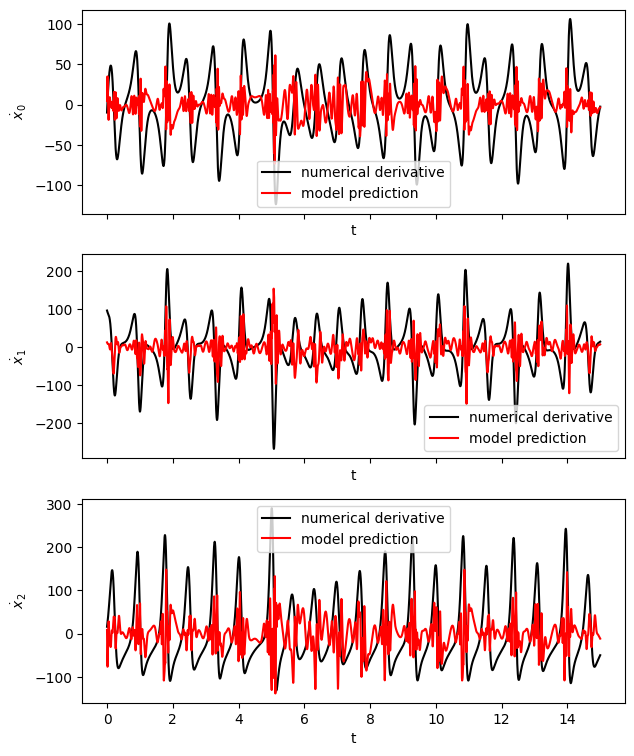

In [ ]:
identity_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
combined_library = identity_library * fourier_library
model = ps.SINDy(feature_library=combined_library, feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()  # prints out long and unobvious model
print("Feature names:", model.get_feature_names())
x_dot_pred = model.predict(x_test)
x_dot_finite_diff = model.differentiate(x_test, t=dt) # compute derivatives with a finite difference method for comparison
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_finite_diff[:, i], "k", label="numerical derivative")
    axs[i].plot(t_test, x_dot_pred[:, i], "r", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
fig.show()

In [ ]:
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
# initialize the default inputs but don't use the x0 input for generating the Fourier library
inputs_per_library = [(0, 1, 2), (1, 2)]
# tensor all the polynomial and Fourier library terms together
tensor_array = [[1, 1]]
# init this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library],
    tensor_array=tensor_array,
    exclude_libraries=[1],
    inputs_per_library=inputs_per_library)
# fit the model and print the library feature names to check success
model = ps.SINDy(feature_library=generalized_library, feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()
print("Feature names:\n", model.get_feature_names())

AttributeError: 'list' object has no attribute 'ndim'

### Chapter Six

Fit a SINDy model to the Lorenz system:
$$\dot{x} = \sigma (y - x) + u_0$$
$$\dot{y} = x(\rho - z) - y$$
$$\dot{z} = x y - \beta z - u_1$$

In [ ]:
# lorenz eq with control input
# def lorenz_control(t, x, u_fun, sigma=10, beta=2.66667, rho=28):
#     u = u_fun(t)
#     return [
#         sigma * (x[1] - x[0]) + u[0, 0],
#         x[0] * (rho - x[2]) - x[1],
#         x[0] * x[1] - beta * x[2] - u[0, 1],
#     ]

In [ ]:
def ufunc(t):
    return np.column_stack([np.sin(2 * t), t**2])
# gen measurement data
dt = 0.002
t_train = np.arange(0, time_end_train, dt)
t_train_span = (t_train[0], t_train[-1])
init_cond_train = [-8, 8, 27]
x_train = solve_ivp(
    lorenz_control,
    t_train_span,
    init_cond_train,
    t_eval=t_train,
    args=(ufunc,),
    **integrator_keywords).y
x_train = x_train.T
u_train = ufunc(t_train)

In [ ]:
# instantiate and fit the SINDYc model
model = ps.SINDy()
model.fit(x_train, u=u_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1 + 0.999 u0
(x1)' = 27.988 x0 + -0.998 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + -1.000 u1 + 1.000 x0 x1


In [ ]:
# evolve the lorenz equations in time using a different initial condition
t_test = np.arange(0, time_end_test, dt)
t_test_span = (t_test[0], t_test[-1])
u_test = ufunc(t_test)
init_cond_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz_control,
    t_test_span,
    init_cond_test,
    t_eval=t_test,
    args=(ufunc,),
    **integrator_keywords).y
x_test = x_test.T
u_test = ufunc(t_test)
print("Model score: %f" % model.score(x_test, u=u_test, t=dt))

Model score: 1.000000


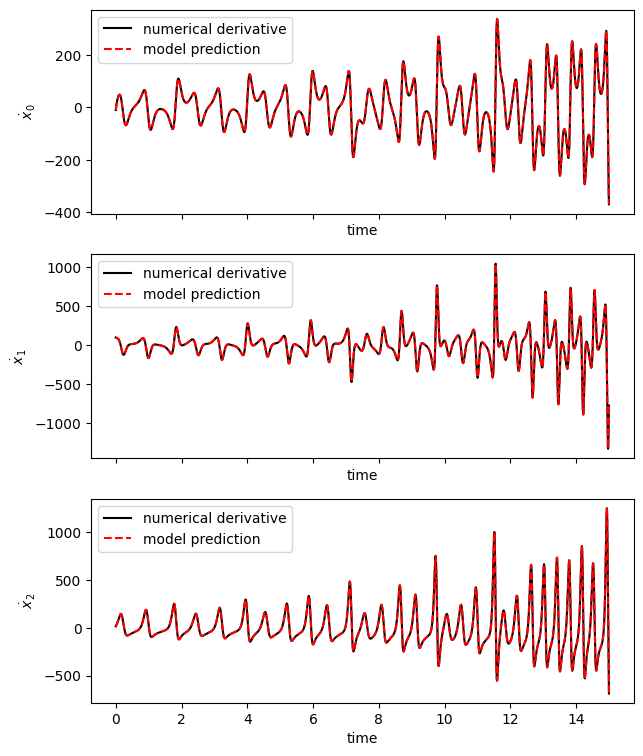

In [ ]:
x_dot_pred = model.predict(x_test, u=u_test)
x_dot_finite_diff = model.differentiate(x_test, t=dt)
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_finite_diff[:, i], "k", label="numerical derivative")
    axs[i].plot(t_test, x_dot_pred[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="time", ylabel=r"$\dot x_{}$".format(i))
fig.show()

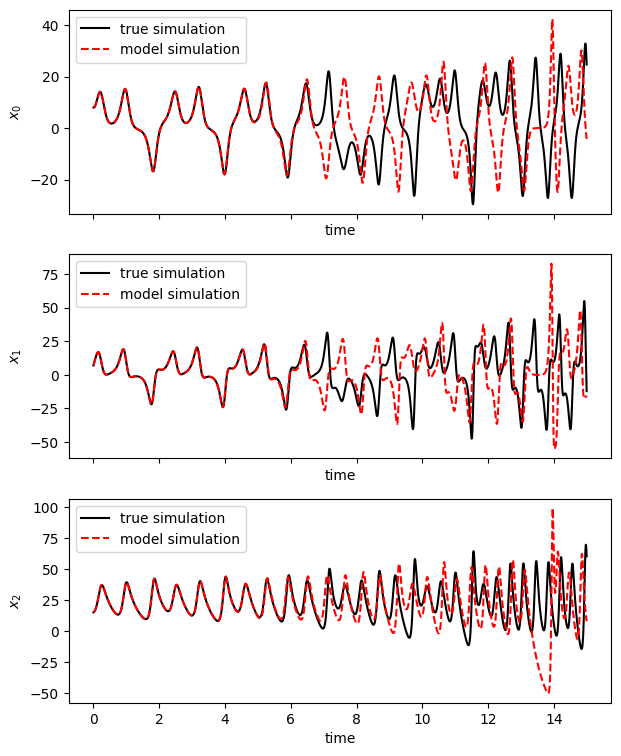

In [ ]:
# evolve the new initial condition in time with the SINDy model
x_simul = model.simulate(init_cond_test, t_test, u=ufunc)
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], "k", label="true simulation")
    axs[i].plot(t_test, x_simul[:, i], "r--", label="model simulation")
    axs[i].legend()
    axs[i].set(xlabel="time", ylabel="$x_{}$".format(i))

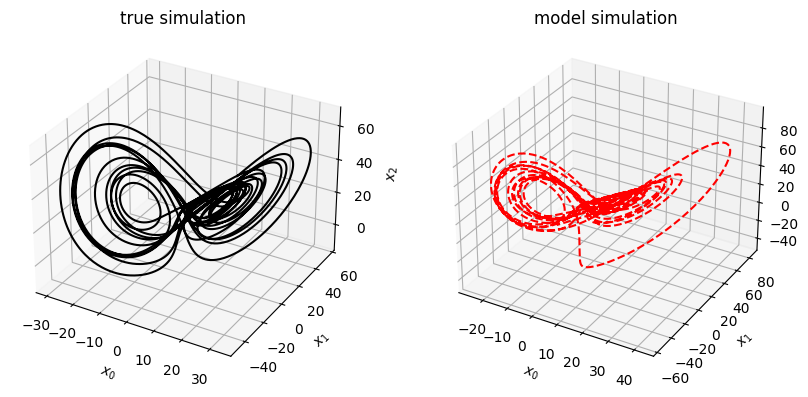

In [ ]:
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k")
ax1.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$", title="true simulation")
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(x_simul[:, 0], x_simul[:, 1], x_simul[:, 2], "r--")
ax2.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$", title="model simulation")
fig.show()

Length of t_test: 7500
Length of simulation: 7499


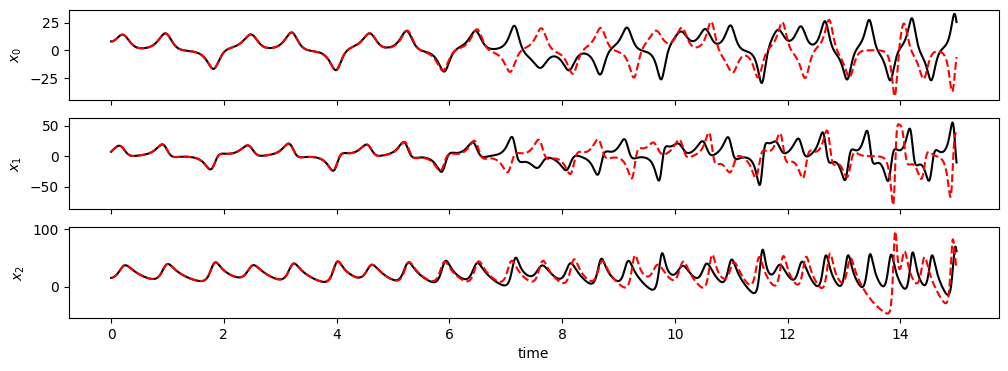

In [ ]:
# unknown control input function
u_test = ufunc(t_test)
x_simul = model.simulate(init_cond_test, t_test, u=u_test)
# note that the output is one example short of the length of t_test
print("Length of t_test:", len(t_test))
print("Length of simulation:", len(x_simul))
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(12, 4))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test[:-1], x_test[:-1, i], "k", label="true simulation")
    axs[i].plot(t_test[:-1], x_simul[:, i], "r--", label="model simulation")
    axs[i].set(ylabel="$x_{}$".format(i))
axs[i].set(xlabel="time")
fig.show()

### Chapter Seven

In [ ]:
# Michaelis–Menten model for enzyme kinetics
# def enzyme(t, x, jx=0.6, Vmax=1.5, Km=0.3):
#     return jx - Vmax * x / (Km + x)
if run_cvxpy:
    dt = 0.001
    if __name__ != "unit_test":
        T = 4
    else:
        T = 0.02
    t = np.arange(0, T + dt, dt)
    t_span = (t[0], t[-1])
    init_cond_train = [0.55]
    x_train = solve_ivp(enzyme, t_span, init_cond_train, t_eval=t, **integrator_keywords).y
    x_train = x_train.T

    # init custom SINDy library so that we can have x_dot inside it.
    x_library_functions = [
        lambda x: x,
        lambda x, y: x * y,
        lambda x: x**2,
        lambda x, y, z: x * y * z,
        lambda x, y: x * y**2,
        lambda x: x**3,
        lambda x, y, z, w: x * y * z * w,
        lambda x, y, z: x * y * z**2,
        lambda x, y: x * y**3,
        lambda x: x**4,
    ]
    x_dot_library_functions = [lambda x: x]

    # lib func names includes both the x_library_functions and x_dot_library_functions names
    library_function_names = [
        lambda x: x,
        lambda x, y: x + y,
        lambda x: x + x,
        lambda x, y, z: x + y + z,
        lambda x, y: x + y + y,
        lambda x: x + x + x,
        lambda x, y, z, w: x + y + z + w,
        lambda x, y, z: x + y + z + z,
        lambda x, y: x + y + y + y,
        lambda x: x + x + x + x,
        lambda x: x,
    ]

    # pass time base to the library so can build the x_dot library from x
    sindy_library = ps.SINDyPILibrary(
        library_functions=x_library_functions,
        x_dot_library_functions=x_dot_library_functions,
        t=t,
        function_names=library_function_names,
        include_bias=True)

    # use the SINDy-PI optimizer, which relies on CVXPY
    # note that if LHS of the equation fits the data poorly CVXPY often returns failure
    sindy_opt = ps.SINDyPI(threshold=1e-6, tol=1e-8, thresholder="l1", max_iter=20000)
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
        differentiation_method=ps.FiniteDifference(drop_endpoints=True))
    model.fit(x_train, t=t)
    model.print()

Model  0
Model  1
Model  2
Model  3
Solver failed on model  3 , setting coefs to zeros
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
1 = 5.000 x0 + 1.667 x0_dot + 5.556 x0x0_dot
x0 = 0.200 1 + -0.333 x0_dot + -1.111 x0x0_dot
x0x0 = 0.198 x0 + 0.007 x0x0x0 + -0.338 x0x0_dot + -1.099 x0x0x0_dot
x0x0x0 = 0.000
x0x0x0x0 = -0.001 1 + 0.363 x0x0x0 + 0.041 x0x0_dot + -1.205 x0x0x0x0x0_dot
x0_dot = 0.600 1 + -3.000 x0 + -3.333 x0x0_dot
x0x0_dot = 0.180 1 + -0.900 x0 + -0.300 x0_dot
x0x0x0_dot = -0.004 1 + 0.136 x0 + -0.508 x0x0 + -0.344 x0x0x0 + -0.102 x0x0_dot + -0.219 x0x0x0x0x0_dot
x0x0x0x0_dot = 0.003 1 + 0.001 x0 + -0.391 x0x0x0 + -0.247 x0x0x0x0 + -0.108 x0x0_dot
x0x0x0x0x0_dot = 0.001 1 + -0.670 x0x0x0x0 + -0.005 x0_dot + 0.029 x0x0_dot + -0.271 x0x0x0_dot


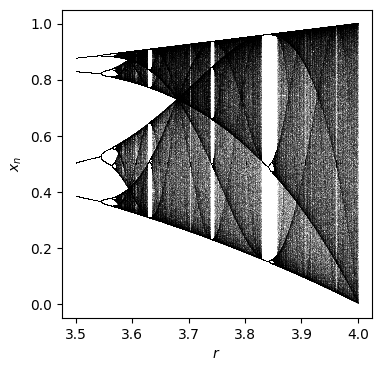

In [ ]:
# iterate the map and drop the initial 500-step transient. The behavior is chaotic for r>3.6
# logit map: x_(n+1) = r * x_(n) * (1-x_(n))
if __name__ != "unit_test":
    num = 1000
    N = 1000
    N_drop = 500
else:
    num = 20
    N = 20
    N_drop = 10
r_o = 3.5
r_n = r_o + np.arange(num) / num * (4 - r_o)
x_m = [] # m = n+1
for r in r_n:
    x_n = []
    x = 0.5
    for n in range(N + N_drop):
        if n >= N_drop:
            x_n = x_n + [x]
        x = r * x * (1 - x)
    x_m = x_m + [x_n]
plt.figure(figsize=(4, 4), dpi=100)
for ind in range(num):
    plt.plot(np.ones(N) * r_n[ind], x_m[ind], ",", alpha=0.1, c="black", rasterized=True)
plt.xlabel("$r$")
plt.ylabel("$x_n$")
plt.show()

In [ ]:
r_n_train = [3.6, 3.7, 3.8, 3.9] # use four parameter values as training data
x_n_train = [np.array(x_m[np.where(np.array(r_n) == r)[0][0]]) for r in r_n_train]
feature_lib = ps.PolynomialLibrary(degree=3, include_bias=True)
parameter_lib = ps.PolynomialLibrary(degree=1, include_bias=True)
lib = ps.ParameterizedLibrary(
    feature_library=feature_lib,
    parameter_library=parameter_lib,
    num_features=1,
    num_parameters=1)
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["x", "r"], discrete_time=True)
model.fit(x_n_train, u=r_n_train)
model.print()

### Chapter Eight

TypeError: 'PolynomialLibrary' object is not iterable

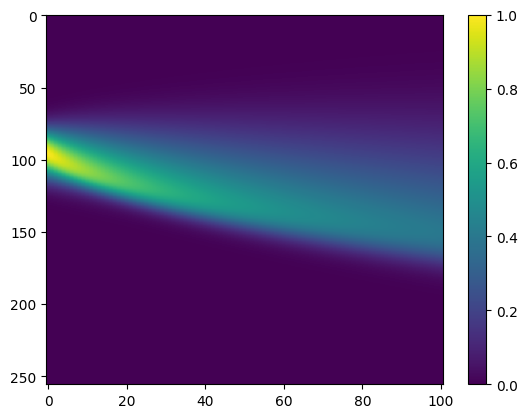

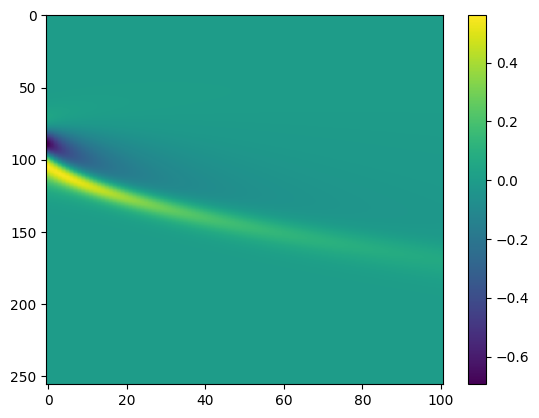

In [ ]:
burgers = loadmat(data / "burgers.mat")
t = np.ravel(burgers["t"])
x = np.ravel(burgers["x"])
u = np.real(burgers["usol"])
dt = t[1] - t[0]
dx = x[1] - x[0]
u_dot = ps.FiniteDifference(axis=-1)._differentiate(u, t=dt)
plt.figure()
plt.imshow(u, aspect="auto")
plt.colorbar()
plt.figure()
plt.imshow(u_dot, aspect="auto")
plt.colorbar()
u = np.reshape(u, (len(x), len(t), 1))

# define quadratic library with up to third order derivatives on a uniform spatial grid. Do not include a constant term in the function_library!
pde_lib = ps.PDELibrary(
    library_functions=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatial_grid=x,
    diff_kwargs={"is_uniform": True, "periodic": True})
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# note that the dimensions of u are reshaped internally according to the dimensions in spatial_grid
model.fit(u, t=dt)
model.print()

In [ ]:
# same library but using the weak formulation
X, T = np.meshgrid(x, t)
XT = np.array([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True)
optimizer = ps.STLSQ(threshold=0.01, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt) # note that reshaping u is done internally
model.print()

TypeError: WeakPDELibrary.__init__() got an unexpected keyword argument 'function_library'

### Chapter Nine

In [ ]:
# Poisson eq for the electric potential in 2D
# define the spatial grid
if __name__ != "unit_test":
    nx = 50
    ny = 100
else:
    nx = 6  # must be even
    ny = 10
Lx = 1
Ly = 1
x = np.linspace(0, Lx, nx)
dx = x[1] - x[0]
y = np.linspace(0, Ly, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y, indexing="ij")
rho = X**2 + Y**2
plt.figure(figsize=(20, 3))
plt.subplot(1, 5, 1)
plt.imshow(rho, aspect="auto", origin="lower")
plt.title(r"$\rho(x, y)$")
plt.colorbar()
# generate the PDE data for phi by fourier transforms since this is homogeneous PDE and we assume periodic boundary conditions
nx2 = int(nx / 2)
ny2 = int(ny / 2)
# define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / Lx) * np.hstack(
    (np.linspace(0, nx2 - 1, nx2), np.linspace(-nx2, -1, nx2))
)
ky = (2 * np.pi / Ly) * np.hstack(
    (np.linspace(0, ny2 - 1, ny2), np.linspace(-ny2, -1, ny2))
)
# get 2D mesh in (kx, ky)
KX, KY = np.meshgrid(kx, ky, indexing="ij")
K2 = KX**2 + KY**2
K2[0, 0] = 1e-5
# generate phi data by solving the PDE and plot results
phi = np.real(np.fft.ifft2(-np.fft.fft2(rho) / K2))
plt.subplot(1, 5, 2)
plt.imshow(phi, aspect="auto", origin="lower")
plt.title(r"$\phi(x, y)$")
plt.colorbar()
# make del^2 phi and plot various quantities
phi_xx = ps.FiniteDifference(d=2, axis=0)._differentiate(phi, dx)
phi_yy = ps.FiniteDifference(d=2, axis=1)._differentiate(phi, dy)
plt.subplot(1, 5, 3)
plt.imshow(phi_xx, aspect="auto", origin="lower")
plt.title(r"$\phi_{xx}(x, y)$")
plt.subplot(1, 5, 4)
plt.imshow(phi_yy, aspect="auto", origin="lower")
plt.title(r"$\phi_{yy}(x, y)$")
plt.subplot(1, 5, 5)
plt.imshow(
    phi_xx + phi_yy + abs(np.min(phi_xx + phi_yy)),
    aspect="auto",
    origin="lower",
)
plt.title(r"$\phi_{xx}(x, y) + \phi_{yy}(x, y)$")
plt.colorbar()
# define a PolynomialLibrary, FourierLibrary, and PDELibrary
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
X_mesh, Y_mesh = np.meshgrid(x, y)
pde_library = ps.PDELibrary(library_functions=ps.CustomLibrary(library_functions=[],function_names=[]),
    derivative_order=1, spatial_grid=np.asarray([X_mesh, Y_mesh]).T)
# inputs are going to be all the variables [phi, X, Y].
# note we can use a subset of these input variables to generate each library
data = np.transpose(np.asarray([phi, X, Y]), [1, 2, 0])
# the 'x_dot' terms will be [phi_xx, X, Y]
# remember these are the things that are being fit in the SINDy regression
Laplacian_phi = phi_xx + phi_yy + abs(np.min(phi_xx + phi_yy))
data_dot = np.transpose(np.asarray([Laplacian_phi, X, Y]), [1, 2, 0])
tensor_array = [[1, 0, 1]] # tensor polynomial library with the PDE library
inputs_per_library = [(0, 1, 2), (0, 1, 2), (0,)] # remove X and Y from PDE library terms because why would we take these derivatives

# fit a generalized library of 3 feature libraries + 1 internally
# generated tensored library and only use the input variable phi
# for the PDELibrary. Note that this holds true both for the
# individual PDELibrary and any tensored libraries constructed from it
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)
optimizer = ps.STLSQ(threshold=8, alpha=1e-3, normalize_columns=True)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(data, x_dot=data_dot)
# note scale of phi is large so some coefficients >> 1
# --> would want to rescale phi with eps_0 for a harder problem
model.print()
# get prediction of rho and plot results
# predict expects a time axis...so add one and ignore it...
data_shaped = data.reshape((data.shape[0], data.shape[1], 1, data.shape[2]))
rho_pred = model.predict(data_shaped)[:, :, 0, :]
if __name__ != "testing":
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.title(r"True $\rho$")
    plt.imshow(rho, aspect="auto", origin="lower")
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.title(r"Predicted $\rho_p$")
    plt.imshow(rho_pred[:, :, 0], aspect="auto", origin="lower")
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.title(r"Residual errors $\rho - \rho_p$")
    plt.imshow(rho - rho_pred[:, :, 0], aspect="auto", origin="lower")
    plt.colorbar()
    print("Feature names:\n", model.get_feature_names())

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<ipython-input-91-cabda1abb97d>, line 81)

### Chapter Ten

In [ ]:
dt = .002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
init_cond_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, init_cond_train,
                    t_eval=t_train, **integrator_keywords).y
x_train = x_train.T
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
init_cond_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, init_cond_test,
                   t_eval=t_test, **integrator_keywords).y
x_test = x_test.T
model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "optimizer__alpha": [0.01, 0.05, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
    "differentiation_method__order": [1, 2]
}
search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train)
print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'differentiation_method__order': 1, 'feature_library': PolynomialLibrary(), 'optimizer__alpha': 0.01, 'optimizer__threshold': 0.01}
(x0)' = -10.021 x0 + 9.993 x1
(x1)' = 0.227 1 + 27.601 x0 + -0.611 x1 + -0.983 x0 x2 + -0.020 x1 x2
(x2)' = 0.590 1 + 0.045 x0 + -0.018 x1 + -2.691 x2 + 0.965 x0 x1 + 0.026 x1^2


In [ ]:
model = ps.SINDy(
    t_default=dt,
    differentiation_method=ps.SINDyDerivative(kind='spline', s=1e-2)
)
param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "differentiation_method__kwargs": [
        {'kind': 'spline', 's': 1e-2},
        {'kind': 'spline', 's': 1e-1},
        {'kind': 'finite_difference', 'k': 1},
        {'kind': 'finite_difference', 'k': 2},
    ]
}
search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train)
print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'differentiation_method__kwargs': {'kind': 'finite_difference', 'k': 2}, 'optimizer__threshold': 0.01}
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.001 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [ ]:
class SINDyCV(ps.SINDy):
    def __init__(self, optimizer=None, feature_library=None, differentiation_method=None, feature_names=None, t_default=1, discrete_time=False):
        super(SINDyCV, self).__init__(
            optimizer=optimizer,
            feature_library=feature_library,
            differentiation_method=differentiation_method,
            feature_names=feature_names,
            t_default=t_default,
            discrete_time=discrete_time)

    def fit(self, x, y, **kwargs):
        return super(SINDyCV, self).fit(x, x_dot=y, **kwargs)

    def score(self, x, y, t=None, u=None, multiple_trajectories=False, metric=r2_score, **metric_kws):
        return super(SINDyCV, self).score(x, x_dot=y, t=t, u=u,
                                          multiple_trajectories=multiple_trajectories,
                                          metric=metric, **metric_kws)
model = SINDyCV()
x_dot = model.differentiate(x_train, t=t_train)
param_grid = {
    "optimizer__threshold": [0.002, 0.01, 0.1],
    "optimizer__alpha": [0.01, 0.05, 0.1],
    "feature_library__degree": [1, 2, 3],
}
search = GridSearchCV(
    model,
    param_grid,
    cv=ShuffleSplit(n_splits=3, test_size=0.25)
)
search.fit(x_train, y=x_dot)
print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library__degree': 2, 'optimizer__alpha': 0.01, 'optimizer__threshold': 0.002}
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [ ]:
model = ps.SINDy(optimizer=ElasticNet(l1_ratio=0.9, fit_intercept=False), t_default=dt)
model.fit(x_train)
model.print()

(x0)' = -10.005 x0 + 10.003 x1
(x1)' = 27.990 x0 + -0.997 x1 + -1.000 x0 x2
(x2)' = -2.665 x2 + 0.001 x0^2 + 0.999 x0 x1


In [ ]:
model = ps.SINDy(optimizer=OrthogonalMatchingPursuit(n_nonzero_coefs=8, fit_intercept=False), t_default=dt)
model.fit(x_train)
model.print()

(x0)' = -10.005 x0 + 10.003 x1
(x1)' = 27.990 x0 + -0.997 x1 + -1.000 x0 x2
(x2)' = -2.665 x2 + 0.001 x0^2 + 0.999 x0 x1


Differentiators in PySINDy: https://pysindy.readthedocs.io/en/latest/examples/5_differentiation/example.html

### Chapter Eleven - DeepTime

Model score: 1.000000
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


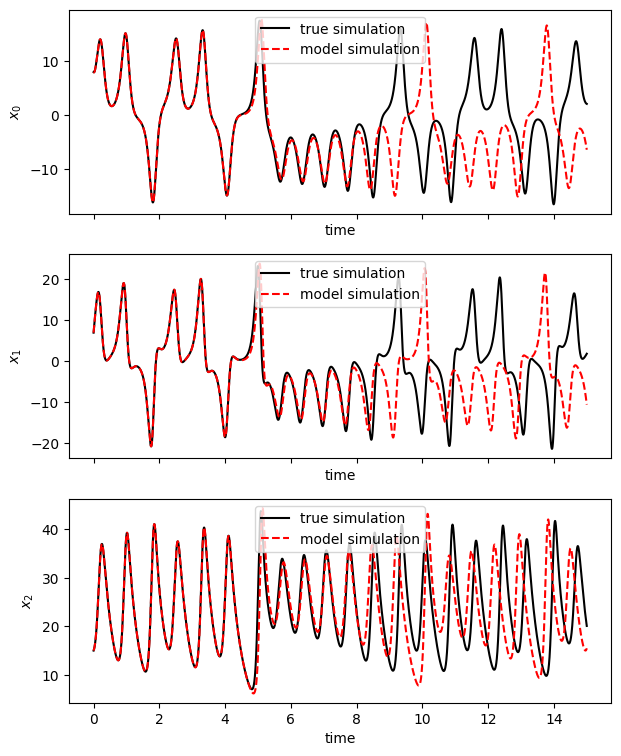

In [ ]:
dt = .002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
init_cond_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, init_cond_train, t_eval=t_train, **integrator_keywords).y.T
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
init_cond_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, init_cond_test, t_eval=t_test, **integrator_keywords).y.T
estimator = ps.deeptime.SINDyEstimator(t_default=dt)
estimator.fit(x_train)
model = estimator.fetch_model()
print('Model score: %f' % model.score(x_test, t=dt))
x_simul = model.simulate(init_cond_test, t_test)
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_simul[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='time', ylabel='$x_{}$'.format(i))
estimator = ps.deeptime.SINDyEstimator(
    optimizer=ps.SR3(threshold=0.5, max_iter=50),
    feature_library=ps.PolynomialLibrary(degree=3))
estimator.fit(x_train, t=dt)
model = estimator.fetch_model()
model.print()